# Laboratorio 3 de Inteligencia Artificial: 
## Modelos de clasificación de datasets "winequality-red" y "winequality-white".

### Integrantes grupo 11: 
- FELIPE ANTONIO BARJA CÁRCAMO
- CRISTIAN FELIPE BERNAL SALINAS
- SEBASTIÁN ALEJANDRO LILLO ACOSTA
- IGNACIO ANDRÉS VALDEBENITO CÁCERES

##### Librerías necesarias

In [333]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.utils import shuffle

##### funciones auxiliares

In [293]:
def add_quality_label(df):
    bins = (2, 5.5, 6.5, 8)
    group_names = ['low-quality', 'average-quality', 'high-quality']
    categories = pd.cut(df['quality'], bins, labels=group_names)
    df['quality_label'] = categories
    return df

## Clasificación para "winequality-red":

### Análisis exploratorio de datos:

In [294]:
red_df = pd.read_csv('winequality-red.csv', delimiter=';')
red_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [295]:
red_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [296]:
red_df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


array([[<AxesSubplot:title={'center':'fixed acidity'}>,
        <AxesSubplot:title={'center':'volatile acidity'}>,
        <AxesSubplot:title={'center':'citric acid'}>,
        <AxesSubplot:title={'center':'residual sugar'}>],
       [<AxesSubplot:title={'center':'chlorides'}>,
        <AxesSubplot:title={'center':'free sulfur dioxide'}>,
        <AxesSubplot:title={'center':'total sulfur dioxide'}>,
        <AxesSubplot:title={'center':'density'}>],
       [<AxesSubplot:title={'center':'pH'}>,
        <AxesSubplot:title={'center':'sulphates'}>,
        <AxesSubplot:title={'center':'alcohol'}>,
        <AxesSubplot:title={'center':'quality'}>],
       [<AxesSubplot:title={'center':'quality_label'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

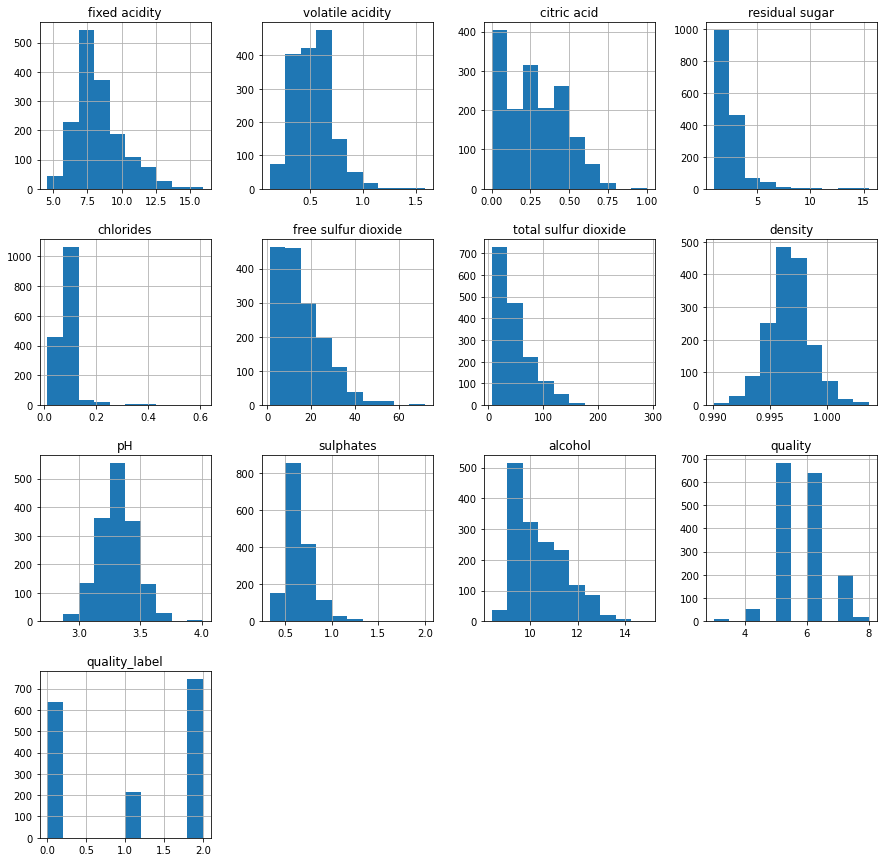

In [337]:
red_df.hist(figsize = (15,15))

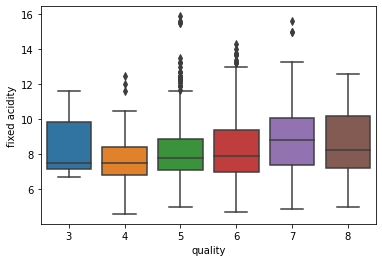

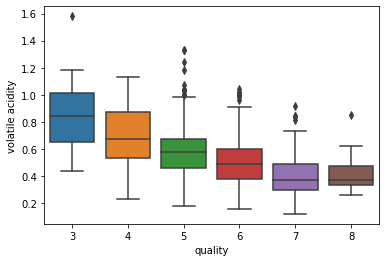

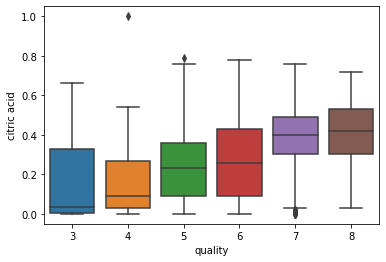

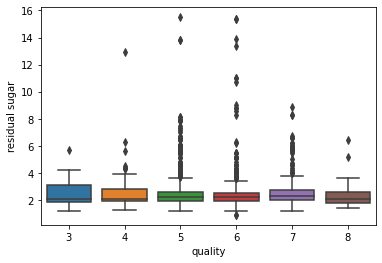

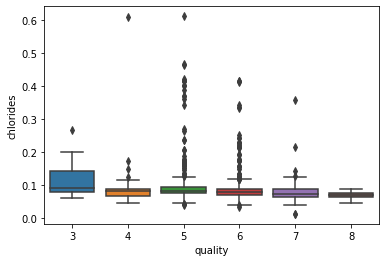

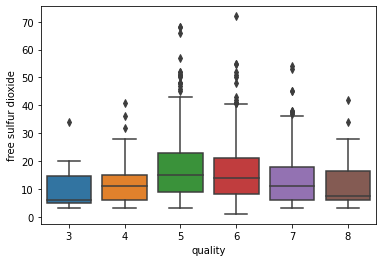

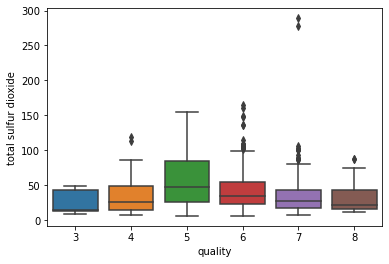

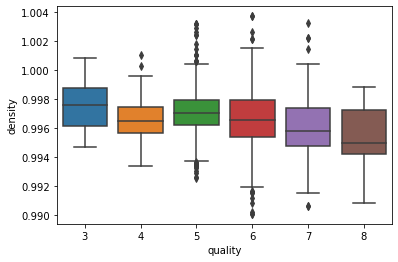

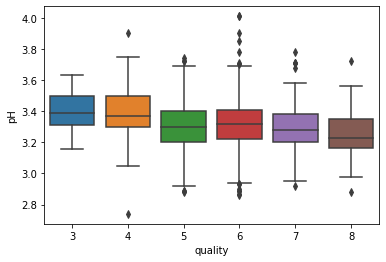

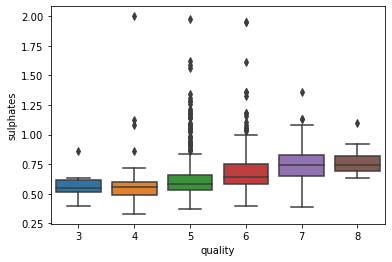

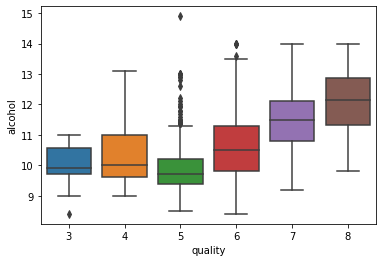

In [297]:
features = red_df.columns
for i in range(1,12):
    sns.boxplot(x='quality', y=features[i-1], data=red_df)
    plt.show()

Añadimos la etiqueta correspondiente a la clasificación que queremos darle. Para los vinos con un valor para "quality" de 3, 4 y 5, asignamos la categoría de "low_quality", para los vinos con valor de 6, se le asigna la categoria "average_quality" y para los vinos con valor de 7,8 se les asigna "high_quality". 

In [298]:
red_df = add_quality_label(red_df)

Luego estas etiquetas las transformamos a numéricas, es decir: 0, 1 y 2 respectivamente.

In [299]:
label_quality = LabelEncoder()

red_df['quality_label'] = label_quality.fit_transform(red_df['quality_label'])

Verificamos el porcentaje de distribución de cada categoría en el dataset.

2    46.529081
0    39.899937
1    13.570982
Name: quality_label, dtype: float64


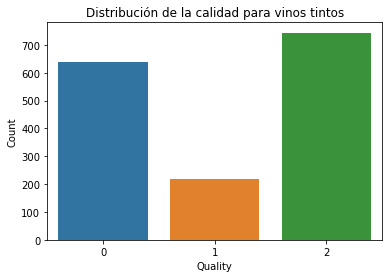

In [300]:
total_samples = len(red_df)
label_counts = red_df['quality_label'].value_counts()
label_proportions = label_counts / total_samples * 100
print(label_proportions)
plt.figure(figsize=(6, 4))
sns.countplot(x='quality_label', data=red_df)
plt.title("Distribución de la calidad para vinos tintos")
plt.xlabel("Quality")
plt.ylabel("Count")
plt.show()

Basándonos en la distribución de calidad del dataset "winequality-red", se observa que:

- La categoría de calidad "2" tiene la mayor proporción con un 46.53% de las muestras.
- La categoría de calidad "0" tiene la siguiente proporción más alta con un 39.90% de las muestras.
- La categoría de calidad "1" tiene la proporción más baja con un 13.57% de las muestras.

En general, podemos observar que el dataset de vinos rojos está desequilibrado, ya que hay una diferencia significativa en la cantidad de muestras entre las diferentes categorías de calidad. Esto puede tener un impacto en el rendimiento de los modelos de clasificación, ya que pueden tener dificultades para aprender patrones y predecir con precisión las clases minoritarias.

Para abordar este desequilibrio de clases, se aplicará una técnica de sobremuestreo (oversampling) de las clases minoritarias (categorías "0" y "1") o el submuestreo de la clase mayoritaria (categoría "2"), con el objetivo de equilibrar la distribución de las clases y mejorar el rendimiento del modelo en la clasificación de todas las categorías de calidad.

Se definen las clases minoritarias:

In [301]:
minority_classes = [0, 1]

Se separan las clases minoritarias y mayoritaria:

In [302]:
minority_data = red_df[red_df['quality_label'].isin(minority_classes)]
majority_data = red_df[~red_df['quality_label'].isin(minority_classes)]

Se calcula el número de muestras de la clase mayoritaria:

In [303]:
n_samples_majority = len(majority_data)

Se generan las muestras adicionales para cada clase minoritaria:

In [304]:
oversampled_data = pd.concat([
    minority_data[minority_data['quality_label'] == cls].sample(
        n=n_samples_majority, replace=True, random_state=42)
    for cls in minority_classes
])

Se combinan las muestras sobremuestreadas con la clase mayoritaria:

In [305]:
oversampled_data = pd.concat([oversampled_data, majority_data])

Se mezclan los datos sobremuestreados

In [306]:
oversampled_redwine_df = shuffle(oversampled_data, random_state=42)

0    33.333333
1    33.333333
2    33.333333
Name: quality_label, dtype: float64


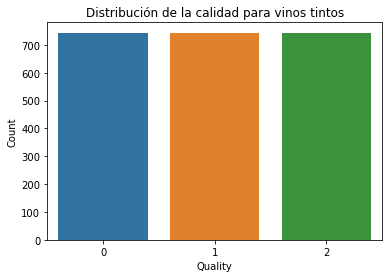

In [307]:
total_samples = len(oversampled_redwine_df)
label_counts = oversampled_data['quality_label'].value_counts()
label_proportions = label_counts / total_samples * 100
print(label_proportions)
# Distribución de la calidad
plt.figure(figsize=(6, 4))
sns.countplot(x='quality_label', data=oversampled_redwine_df)
plt.title("Distribución de la calidad para vinos tintos")
plt.xlabel("Quality")
plt.ylabel("Count")
plt.show()

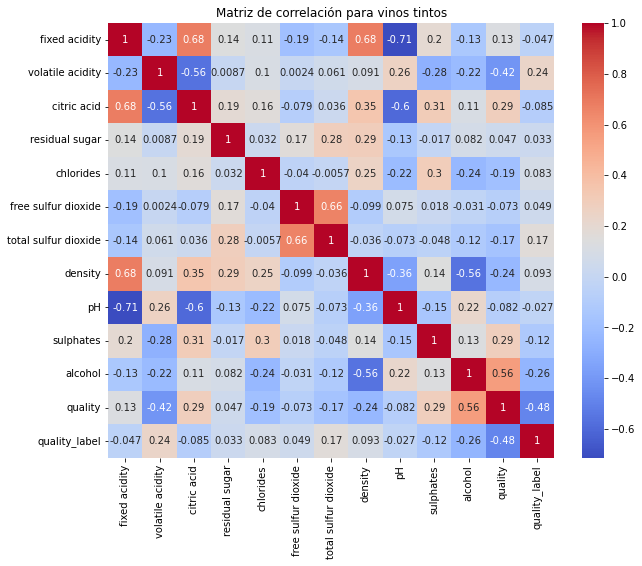

In [308]:
# Matriz de correlación
plt.figure(figsize=(10, 8))
correlation_red = oversampled_redwine_df.corr()
sns.heatmap(correlation_red, annot=True, cmap="coolwarm")
plt.title("Matriz de correlación para vinos tintos")
plt.show()

### Entrenamiento de los modelos de clasificación

Primero, se separan las características de las etiquetas

In [309]:
X_red = oversampled_redwine_df.drop(['quality', 'quality_label'], axis=1)
Y_red = oversampled_redwine_df['quality_label']

Se realiza la división en conjuntos de entrenamiento y prueba

In [310]:
X_red_train, X_red_test, y_red_train, y_red_test = train_test_split(X_red, Y_red, test_size=0.2, random_state=42)

In [311]:
sc = StandardScaler()

X_train = sc.fit_transform(X_red_train)
X_test = sc.fit_transform(X_red_test)

Se inicializan los modelos de clasficación

In [312]:
redwine_svm = SVC(kernel='linear',verbose=False)
redwine_tree = DecisionTreeClassifier()
redwine_forest = RandomForestClassifier()

Se entrena cada modelo con cada set de entrenamiento y se testea con el set de prueba correspondiente en cada uno.

In [313]:
for model, name in zip([redwine_svm, redwine_tree, redwine_forest], ['SVC', 'Decision Tree', 'Random Forest']):
    for wine, X_train, X_test, Y_train, Y_test in zip(['Red Wine'], [X_red_train], [X_red_test], 
                                                       [y_red_train], 
                                                       [y_red_test]):
        model.fit(X_train, Y_train)
        predictions = model.predict(X_test)
        confusion = confusion_matrix(Y_test, predictions)
        scores = cross_val_score(model, X_test, Y_test, cv=10)
        print(f'{name} model average accuracy on {wine}: {scores.mean()}')
        plot_confusion_matrix(cm,class_name)
        print('-' * 100)

SVC model average accuracy on Red Wine: 0.5905050505050504
Matriz de confusión para SVC en Red Wine:
[[ 51  40  53]
 [ 54  98   8]
 [ 28   6 109]]

Decision Tree model average accuracy on Red Wine: 0.6803535353535354
Matriz de confusión para Decision Tree en Red Wine:
[[119   6  19]
 [  3 156   1]
 [ 26   7 110]]

Random Forest model average accuracy on Red Wine: 0.718080808080808
Matriz de confusión para Random Forest en Red Wine:
[[120   5  19]
 [  3 156   1]
 [ 18   2 123]]



Estos resultados se pueden interpretar de la siguiente manera: 

#### Modelo con SVM: 

Este logra una precisión promedio de aproximadamente 0.59, lo que significa que clasifica correctamente alrededor del 59% de las muestras del conjunto de datos de vino tinto. este logra una precisión promedio de aproximadamente 0.59, lo que significa que clasifica correctamente alrededor del 59% de las muestras del conjunto de datos de vino tinto.

#### Modelo con árbol de decisión:

Este logra una precisión promedio de aproximadamente 0.66, lo que significa que clasifica correctamente alrededor del 66% de las muestras del conjunto de datos de vino tinto. Al observar la matriz de confusión, se puede notar que el modelo de árbol de decisión tiene un mejor desempeño que el modelo SVC en la clasificación de las muestras. Hay menos confusión en la clasificación de las tres categorías de calidad. En este caso se observan 2 niveles de profundidad para el 'arbol de decisión que clasifica los vinos tintos. 




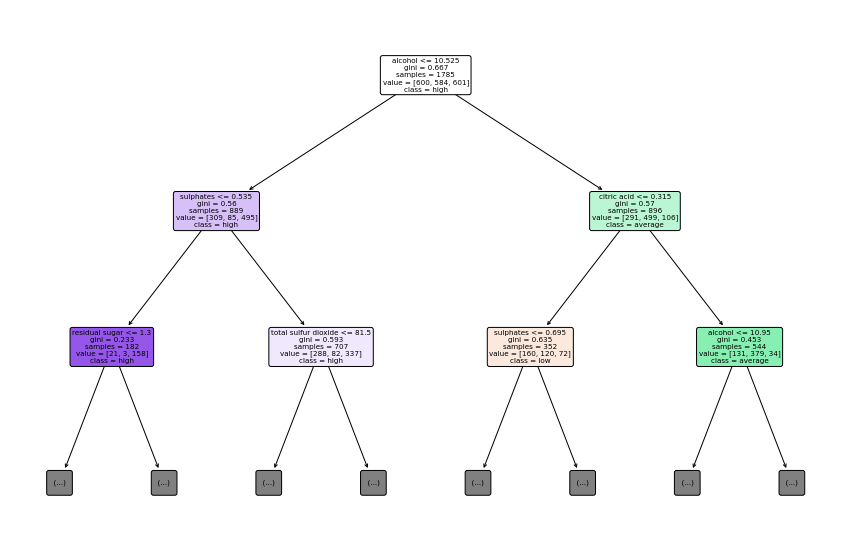

In [336]:
plt.figure(figsize=(15,10))
plot_tree(redwine_tree, 
          filled=True, 
          rounded=True, 
          feature_names=X_red.columns, 
          class_names=['low', 'average', 'high'],
          max_depth=2)
plt.show()

El nodo de la izquierda utiliza la característica "sulphates" y establece la condición de que el valor de "sulphates" debe ser menor o igual a 0.535 para seguir por esta rama del árbol.

El índice de impureza de Gini en este nodo es de 0.56, lo que indica que la distribución de los valores de calidad en este subgrupo de muestras está relativamente mezclada.

El número de muestras en este nodo es de 889, lo que implica que se basa en un subconjunto de datos de entrenamiento de ese tamaño.

La distribución de valores de la etiqueta en este nodo muestra que hay 309 muestras clasificadas como "high", 85 muestras clasificadas como "average" y 495 muestras clasificadas como "low". Esto indica la proporción de cada clase en este subgrupo de muestras.

La clase predicha para las muestras que cumplen la condición establecida en este nodo es "high".

El nodo de la derecha utiliza la característica "citric acid" y establece la condición de que el valor de "citric acid" debe ser menor o igual a 0.315 para seguir por esta rama del árbol.

El índice de impureza de Gini en este nodo es de 0.57, lo que indica que la distribución de los valores de calidad en este subgrupo de muestras también está relativamente mezclada.

El número de muestras en este nodo es de 896, lo que implica que se basa en un subconjunto de datos de entrenamiento de ese tamaño.

La distribución de valores de la etiqueta en este nodo muestra que hay 291 muestras clasificadas como "high", 499 muestras clasificadas como "average" y 106 muestras clasificadas como "low". Esto indica la proporción de cada clase en este subgrupo de muestras.

La clase predicha para las muestras que cumplen la condición establecida en este nodo es "average".

#### Modelo con Random Forest:

Este logra una precisión promedio de aproximadamente 0.71, lo que significa que clasifica correctamente alrededor del 71% de las muestras del conjunto de datos de vino tinto. Al analizar la matriz de confusión, se puede observar que el modelo Random Forest tiene un rendimiento aún mejor que los modelos anteriores en la clasificación de las muestras. La confusión en la clasificación de las tres categorías de calidad es menor en comparación con los otros modelos.

Se visualiza uno de los árboles generados por RandomForest. Aquí se observan los primeros 2 niveles de profundidad. 

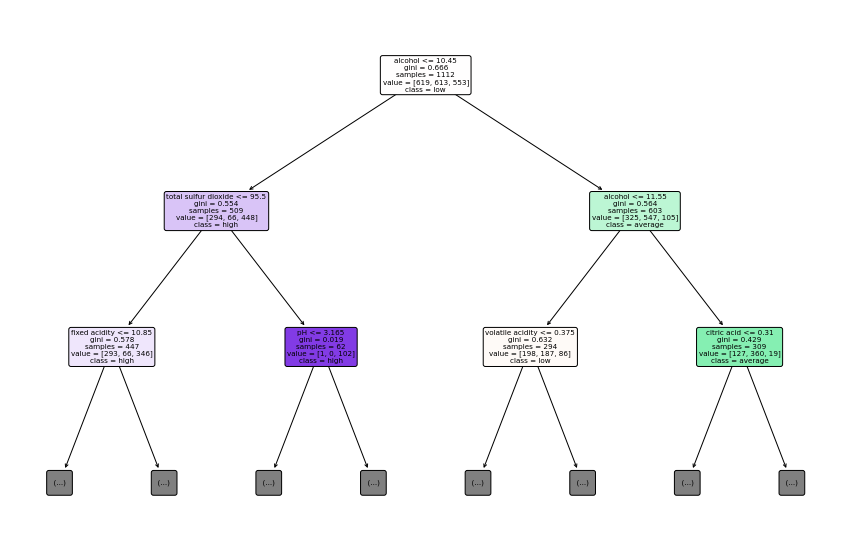

In [315]:
plt.figure(figsize=(15,10))
plot_tree(redwine_forest.estimators_[0], 
          filled=True, 
          rounded=True, 
          feature_names=X_red.columns, 
          class_names=['low', 'average', 'high'],
          max_depth=2)
plt.show()

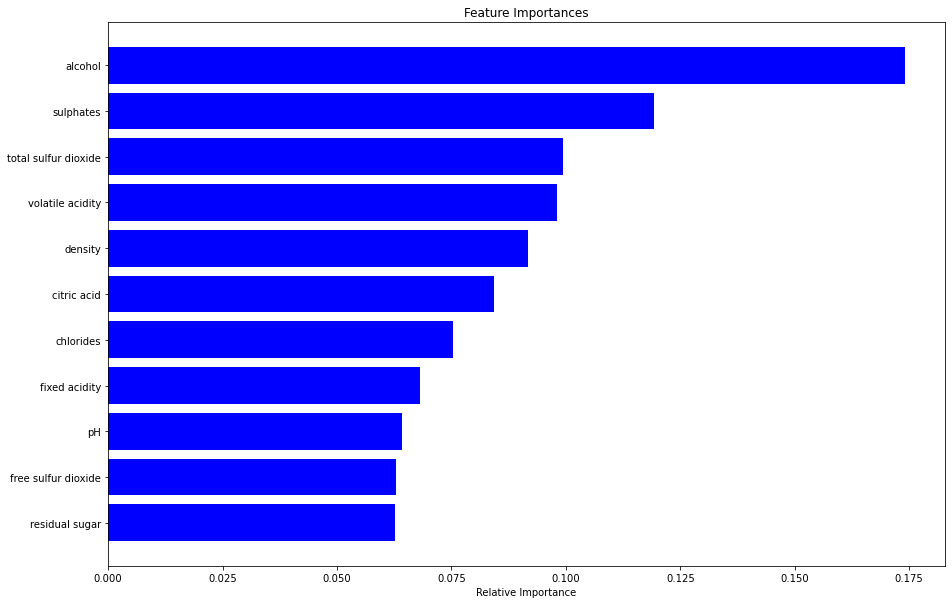

In [316]:
importances = redwine_forest.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(15,10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [X_red.columns[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## Clasificación para "winequality-white":

### Análisis exploratorio de datos:

In [317]:
white_df = pd.read_csv('winequality-white.csv',delimiter=';')
white_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [318]:
white_df = add_quality_label(white_df)

In [319]:
label_quality = LabelEncoder()

white_df['quality_label'] = label_quality.fit_transform(white_df['quality_label'])

In [320]:
white_df = white_df[white_df['quality_label'] != 3]

In [321]:
total_samples = len(white_df)
label_counts = white_df['quality_label'].value_counts()
label_proportions = label_counts / total_samples * 100
print(label_proportions)

0    44.921316
2    33.517270
1    21.561414
Name: quality_label, dtype: float64


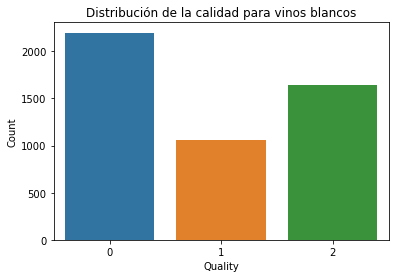

In [322]:
# Distribución de la calidad
plt.figure(figsize=(6, 4))
sns.countplot(x='quality_label', data=white_df)
plt.title("Distribución de la calidad para vinos blancos")
plt.xlabel("Quality")
plt.ylabel("Count")
plt.show()

Basándonos en la distribución de calidad del dataset "winequality-white", se observa que:

- La categoría de calidad "0" tiene la mayor proporción con un 44.92% de las muestras.
- La categoría de calidad "2" tiene la siguiente proporción más alta con un 33.52% de las muestras.
- La categoría de calidad "1" tiene la proporción más baja con un 21.56% de las muestras.

Similar al caso del dataset "winequality-red", podemos observar que el dataset de vinos blancos también está desequilibrado, ya que hay una diferencia significativa en la cantidad de muestras entre las diferentes categorías de calidad. Esto puede afectar el rendimiento de los modelos de clasificación al tener dificultades para aprender patrones y predecir con precisión las clases minoritarias.

Para abordar este desequilibrio de clases en el dataset de vinos blancos, también se aplicará sobremuestreo de las clases minoritarias (categorías "1" y "2") o el submuestreo de la clase mayoritaria (categoría "0"), con el objetivo de equilibrar la distribución de las clases y mejorar el rendimiento del modelo en la clasificación de todas las categorías de calidad.

Entonces, se identifican las clases minoritarias

In [338]:
minority_classes = [1, 2]

Separamos las clases minoritarias y mayoritaria


In [324]:
minority_data = white_df[white_df['quality_label'].isin(minority_classes)]
majority_data = white_df[~white_df['quality_label'].isin(minority_classes)]

Se calcula el número de muestras de la clase mayoritaria

In [325]:
n_samples_majority = len(majority_data)

Se generan las muestras adicionales para cada clase minoritaria

In [326]:
oversampled_data = pd.concat([
    minority_data[minority_data['quality_label'] == cls].sample(
        n=n_samples_majority, replace=True, random_state=42)
    for cls in minority_classes
])

Se combinan las muestras sobremuestreadas con la clase mayoritaria

In [327]:
oversampled_data = pd.concat([oversampled_data, majority_data])

Finalmente, se mezclan los datos sobremuestreados

In [328]:
oversampled_whitewine_df = shuffle(oversampled_data, random_state=42)

obteniendo la siguiente distribución:

In [329]:
total_samples = len(oversampled_whitewine_df)
label_counts = oversampled_data['quality_label'].value_counts()
label_proportions = label_counts / total_samples * 100
print(label_proportions)

1    33.333333
2    33.333333
0    33.333333
Name: quality_label, dtype: float64


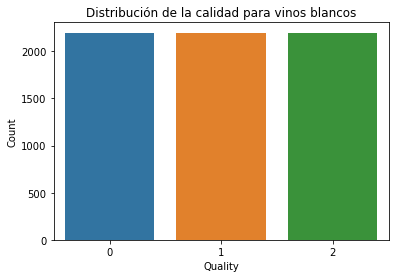

In [330]:
# Distribución de la calidad
plt.figure(figsize=(6, 4))
sns.countplot(x='quality_label', data=oversampled_whitewine_df)
plt.title("Distribución de la calidad para vinos blancos")
plt.xlabel("Quality")
plt.ylabel("Count")
plt.show()

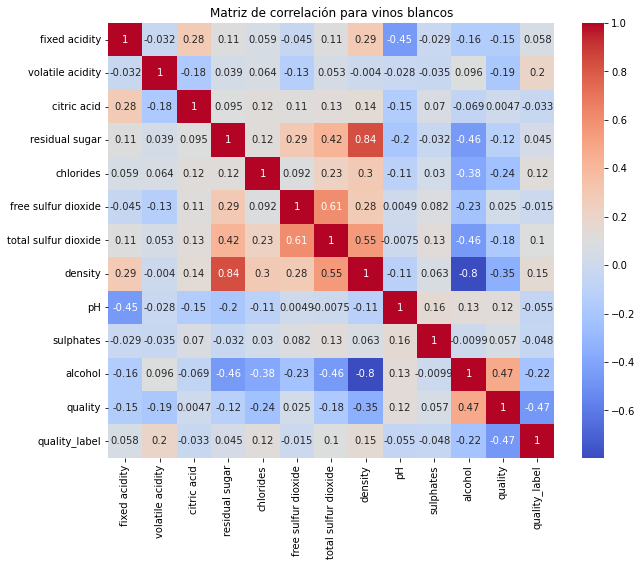

In [331]:
# Matriz de correlación
plt.figure(figsize=(10, 8))
correlation_red = oversampled_whitewine_df.corr()
sns.heatmap(correlation_red, annot=True, cmap="coolwarm")
plt.title("Matriz de correlación para vinos blancos")
plt.show()

### Entrenamiento de los modelos de clasificación

Primero, se separan las características de las etiquetas

In [342]:
X_white = oversampled_whitewine_df.drop(['quality', 'quality_label'], axis=1)
Y_white = oversampled_whitewine_df['quality_label']

Luego, se realiza la división en conjuntos de entrenamiento y prueba

In [343]:
X_white_train, X_white_test, y_white_train, y_white_test = train_test_split(X_white, Y_white, test_size=0.2, random_state=42)

Se inicializan los modelos de clasificación

In [344]:
whitewine_svm = SVC(kernel='linear',verbose=False)
whitewine_tree = DecisionTreeClassifier()
whitewine_forest = RandomForestClassifier()

In [345]:
whitewine_svm.fit(X_white_train[selected_features],y_white_train)
predictions = model.predict(X_white_test)
confusion = confusion_matrix(y_white_test, predictions)
scores = cross_val_score(model, X_white_test, y_white_test, cv=10)
print(f'SVM model average accuracy on White Wine: {scores.mean()}')
print(f'Matriz de confusión para SVM en White Wine:\n{confusion}\n')

SVM model average accuracy on White Wine: 0.6663717325931067
Matriz de confusión para SVM en White Wine:
[[104 105 254]
 [142 205  95]
 [ 64  29 321]]



Se entrena cada modelo con cada set de entrenamiento y se testea con el set de prueba correspondiente en cada uno.

In [ ]:
for model, name in zip([whitewine_svm,whitewine_tree, whitewine_forest], ['SVC', 'Decision Tree', 'Random Forest']):
    for wine, X_train, X_test, Y_train, Y_test in zip(['White Wine'], [ X_white_train], [X_white_test], 
                                                       [y_white_train], 
                                                       [y_white_test]):
        model.fit(X_train, Y_train)
        predictions = model.predict(X_test)
        confusion = confusion_matrix(Y_test, predictions)
        scores = cross_val_score(model, X_test, Y_test, cv=10)
        print(f'{name} model average accuracy on {wine}: {scores.mean()}')
        print(f'Matriz de confusión para {name} en {wine}:\n{confusion}\n')

KeyboardInterrupt: 

En este caso se observan 2 niveles de profundidad para el arbol de decisión que clasifica los vinos blancos.

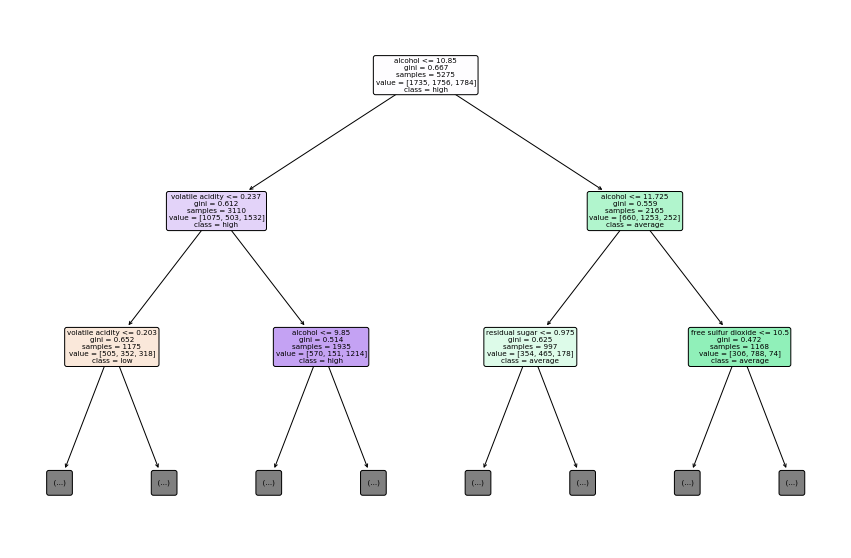

In [ ]:
plt.figure(figsize=(15,10))
plot_tree(whitewine_tree, 
          filled=True, 
          rounded=True, 
          feature_names=X_white.columns, 
          class_names=['low', 'average', 'high'],
          max_depth=2)

plt.show()

Se visualiza uno de los árboles generados por RandomForest. Aquí se observan los primeros 2 niveles de profundidad. 

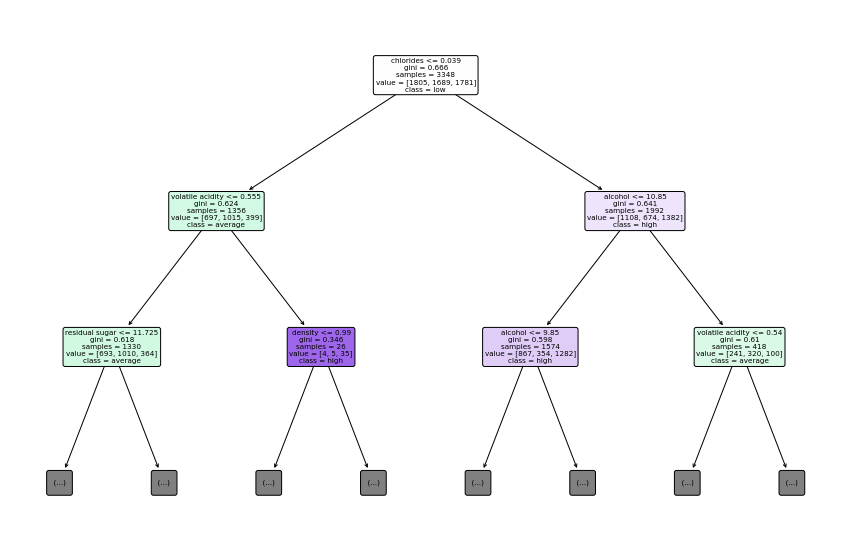

In [ ]:
plt.figure(figsize=(15,10))
plot_tree(whitewine_forest.estimators_[0], 
          filled=True, 
          rounded=True, 
          feature_names=X_white.columns, 
          class_names=['low', 'average', 'high'],
          max_depth=2)
plt.show()

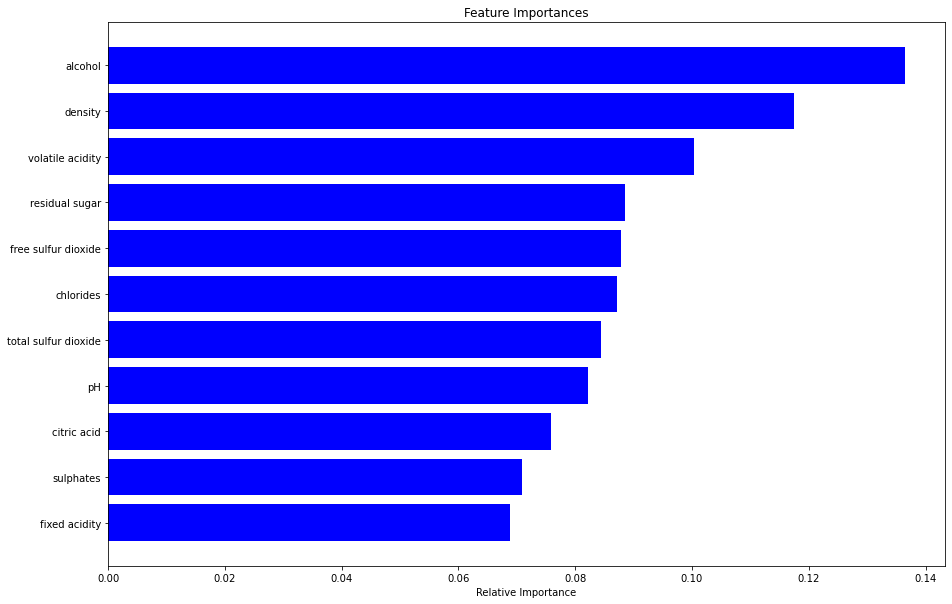

In [ ]:
importances = whitewine_forest.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(15,10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [X_white.columns[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()